In [10]:
from ib_insync import *
from matplotlib import pyplot as plt
import math
util.startLoop()

ib = IB()
ib.connect('127.0.0.1', 4001, clientId=4)

<IB connected to 127.0.0.1:4001 clientId=4>

In [23]:
spx = Contract(symbol='SPX',secType='IND')
ndx = Contract(symbol='NDX',secType='IND')
ib.qualifyContracts(spx)
ib.reqHeadTimeStamp(spx,whatToShow='TRADES', useRTH=True)
ib.qualifyContracts(ndx)
ib.reqHeadTimeStamp(ndx,whatToShow='TRADES', useRTH=True)
print(spx)
print(ndx)
spx_bars=ib.reqHistoricalData(
    contract=spx,
    endDateTime='',
    durationStr='60 S',
    barSizeSetting='1 secs',
    whatToShow='TRADES',
    useRTH=False,
    formatDate='1'
)
ndx_bars=ib.reqHistoricalData(
    contract=ndx,
    endDateTime='',
    durationStr='60 S',
    barSizeSetting='1 secs',
    whatToShow='TRADES',
    useRTH=False,
    formatDate='1'
)
print(spx_bars[0])

Contract(secType='IND', conId=416904, symbol='SPX', exchange='CBOE', currency='USD', localSymbol='SPX')
Contract(secType='IND', conId=416843, symbol='NDX', exchange='NASDAQ', currency='USD', localSymbol='NDX')
BarData(date=datetime.datetime(2023, 4, 11, 12, 59), open=4107.77, high=4107.77, low=4107.77, close=4107.77, volume=0.0, average=0.0, barCount=1)


Error 1100, reqId -1: Connectivity between IB and Trader Workstation has been lost.
Error 1100, reqId -1: Connectivity between IB and Trader Workstation has been lost.
Error 1100, reqId -1: Connectivity between IB and Trader Workstation has been lost.
Error 1100, reqId -1: Connectivity between IB and Trader Workstation has been lost.
Error 1100, reqId -1: Connectivity between IB and Trader Workstation has been lost.


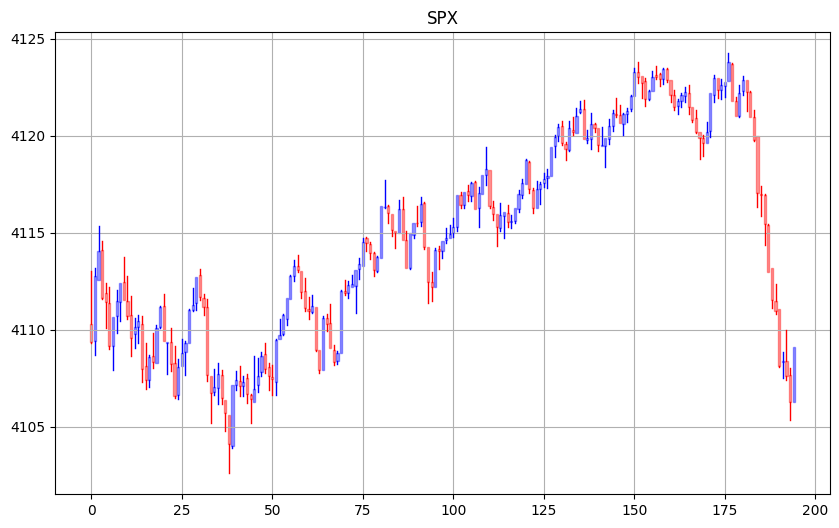

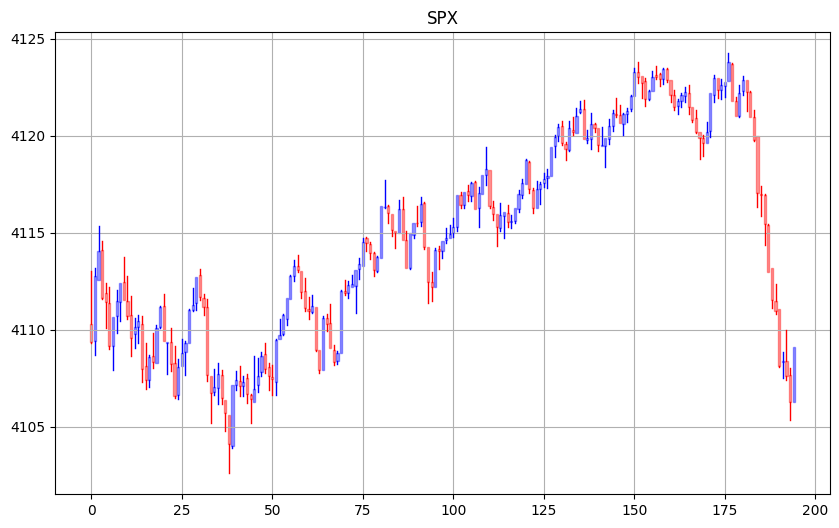

In [5]:
spx=Contract(symbol='SPX',secType='IND')
ib.qualifyContracts(spx)
ib.reqHeadTimeStamp(spx,whatToShow='TRADES', useRTH=True)
bars=ib.reqHistoricalData(
    contract=spx,
    endDateTime='',
    durationStr='1 D',
    barSizeSetting='2 mins',
    whatToShow='TRADES',
    useRTH=True,
    formatDate='1'
)
df=util.df(bars)
#plt.plot(df['close'])
util.barplot(bars, title=spx.symbol)

In [9]:
[ticker]=ib.reqTickers(spx)
spxVal=ticker.marketPrice()
if math.isnan(spxVal):
    spxVal=bars[-1].close
print('spx='+str(spxVal))
chains=ib.reqSecDefOptParams(spx.symbol,'',spx.secType, spx.conId)
#print('Chains='+str(chains))
chain=next(c for c in chains if c.tradingClass=='SPXW' and c.exchange=='SMART')
#print(chain)
strikes=[stk for stk in chain.strikes if stk%5==0 and spxVal-150<stk<spxVal-50]
expiration=sorted(exp for exp in chain.expirations)[:1]
rights=['P']
contracts=[Option('SPX',exp,stk,right,'SMART')
           for right in rights
           for exp in expiration
           for stk in strikes]

contracts=ib.qualifyContracts(*contracts)
#print(contracts)
tickers=ib.reqTickers(*contracts)


spx=4109.13


Error 1100, reqId -1: Connectivity between IB and Trader Workstation has been lost.
[WinError 10054] 远程主机强迫关闭了一个现有的连接。


In [8]:
for ticker in tickers:
    print(ticker)

Ticker(contract=Option(conId=620554085, symbol='SPX', lastTradeDateOrContractMonth='20230412', strike=3960.0, right='P', multiplier='100', exchange='SMART', currency='USD', localSymbol='SPXW  230412P03960000', tradingClass='SPXW'), time=datetime.datetime(2023, 4, 12, 6, 51, 38, 197106, tzinfo=datetime.timezone.utc), minTick=0.05, bid=0.05, bidSize=720.0, bidExchange='C', ask=0.15, askSize=387.0, askExchange='C', last=0.15, lastSize=1.0, volume=106.0, high=0.85, low=0.1, close=0.25, bidGreeks=OptionComputation(tickAttrib=0, impliedVol=0.3706673072567033, delta=-0.005169815944983447, optPrice=0.05000000074505806, pvDividend=0.0, gamma=0.0002525958820880815, vega=0.023699259126741198, theta=-0.05000000074505806, undPrice=4107.7578125), askGreeks=OptionComputation(tickAttrib=0, impliedVol=0.41764947454123424, delta=-0.01137756879835683, optPrice=0.15000000596046448, pvDividend=0.0, gamma=0.0004488201621037405, vega=0.0474469737751054, theta=-0.15000000596046448, undPrice=4107.7578125), las

In [78]:
import spread_util
short_leg=[ticker for ticker in tickers if (ticker.lastGreeks.delta != None)\
           and(0.04<=abs(ticker.lastGreeks.delta)<=0.06)][0]
long_leg=[ticker for ticker in tickers if ticker.contract.strike==(short_leg.contract.strike-20)][0]
short_leg=ib.reqTickers(short_leg.contract)[0] #update price
long_leg=ib.reqTickers(long_leg.contract)[0]
spread_contract=spread_util.create_vertical_spread(long_leg.contract,short_leg.contract)
spread_price=long_leg.ask-short_leg.bid
spread_order=LimitOrder('BUY',5,spread_price)
trade=ib.placeOrder(spread_contract,spread_order)

ib.sleep(0.5)
print(trade.log)

[TradeLogEntry(time=datetime.datetime(2022, 10, 17, 6, 30, 55, 204645, tzinfo=datetime.timezone.utc), status='PendingSubmit', message='', errorCode=0), TradeLogEntry(time=datetime.datetime(2022, 10, 17, 6, 30, 55, 274144, tzinfo=datetime.timezone.utc), status='PreSubmitted', message='', errorCode=0)]


In [92]:
import spread_util
spread_util.calc_spread_price(ib, spread_util.SpreadType.BULLPUT,long_leg.contract,short_leg.contract,0)




AttributeError: BULLPUT

In [3]:
ib.disconnect()